In [33]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from io import BytesIO
import zipfile
import geopandas as gpd
from lxml import html
from fastkml import kml
import fiona




In [10]:
# Specify the path to the KMZ file
kmz_path = r"C:\Users\israe\Desktop\Files\Coding\Repos\WW_Project\WW 2023 locations.xlsx.kmz"

# Open the KMZ file and read the content of the 'doc.kml' file
with zipfile.ZipFile(kmz_path, 'r') as kmz:
    kml_content = kmz.read('doc.kml')

In [17]:
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

gdf_list = []

# Read KML content as bytes using BytesIO
with BytesIO(kml_content) as kml_bytes:
    # Use gpd.read_file to directly read the KML content
    gdf = gpd.read_file(kml_bytes, driver='LIBKML')
    gdf_list.append(gdf)

# Concatenate the list of GeoDataFrames into a single GeoDataFrame
final_gdf = pd.concat(gdf_list, ignore_index=True)

# Display the resulting GeoDataFrame
print(final_gdf)

                             Name  \
0                         La Mota   
1          102nd St Market & Deli   
2            GATEWAY LIQUOR STORE   
3                Natural Remedies   
4                  Nectar - Stark   
..                            ...   
598              WW-Box (Coquine)   
599      WW-Box (Bipartisan Cafe)   
600               THE GREEN FRONT   
601      WW-Box (Fillmore Coffee)   
602  WW-Box (Glisan Street Pizza)   

                                           description timestamp begin end  \
0    Address: 4999 NE 99th Ave<br>City, State: Port...       NaT   NaT NaT   
1    Address: 4646 NE 102nd Ave<br>City, State: Por...       NaT   NaT NaT   
2    Address: 10320 NE HALSEY<br>City, State: Portl...       NaT   NaT NaT   
3    Address: 9810 E Burnside St<br>City, State: Po...       NaT   NaT NaT   
4    Address: 9127 SE Stark<br>City, State: Portlan...       NaT   NaT NaT   
..                                                 ...       ...   ...  ..   
598  Addr

In [19]:
final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Name          603 non-null    object        
 1   description   603 non-null    object        
 2   timestamp     0 non-null      datetime64[ns]
 3   begin         0 non-null      datetime64[ns]
 4   end           0 non-null      datetime64[ns]
 5   altitudeMode  0 non-null      object        
 6   tessellate    0 non-null      object        
 7   extrude       0 non-null      object        
 8   visibility    603 non-null    int64         
 9   drawOrder     0 non-null      object        
 10  icon          0 non-null      object        
 11  Address       603 non-null    object        
 12  City__State   603 non-null    object        
 13  geometry      0 non-null      geometry      
dtypes: datetime64[ns](3), geometry(1), int64(1), object(9)
memory usage: 66.1+ KB


In [29]:
ww_boxes = final_gdf.loc[:,['Name','Address']].copy()
print(ww_boxes)

                             Name             Address
0                         La Mota    4999 NE 99th Ave
1          102nd St Market & Deli   4646 NE 102nd Ave
2            GATEWAY LIQUOR STORE     10320 NE HALSEY
3                Natural Remedies  9810 E Burnside St
4                  Nectar - Stark       9127 SE Stark
..                            ...                 ...
598              WW-Box (Coquine)  6839 SE Belmont St
599      WW-Box (Bipartisan Cafe)    7901 SE Stark St
600               THE GREEN FRONT      6814 NE GLISAN
601      WW-Box (Fillmore Coffee)   7201 NE Glisan St
602  WW-Box (Glisan Street Pizza)   8001 NE Glisan St

[603 rows x 2 columns]


In [30]:
def clean_name(Name):
    # Check if the place name starts with "WW-Box"
    if Name.startswith("WW-Box"):
        # Remove "WW-Box" and leading whitespace, then title case the remaining part
        return Name.split("(")[-1].strip().title().rstrip(')')
    else:
        # Title case the entire place name
        return Name.title()

ww_boxes['Name'] = ww_boxes['Name'].apply(clean_name)

print (ww_boxes)



                       Name             Address
0                   La Mota    4999 NE 99th Ave
1    102Nd St Market & Deli   4646 NE 102nd Ave
2      Gateway Liquor Store     10320 NE HALSEY
3          Natural Remedies  9810 E Burnside St
4            Nectar - Stark       9127 SE Stark
..                      ...                 ...
598                 Coquine  6839 SE Belmont St
599         Bipartisan Cafe    7901 SE Stark St
600         The Green Front      6814 NE GLISAN
601         Fillmore Coffee   7201 NE Glisan St
602     Glisan Street Pizza   8001 NE Glisan St

[603 rows x 2 columns]


C:\Users\israe\AppData\Local\Temp\ipykernel_3144\2618427464.py:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  oregon = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: aspect must be finite and positive 

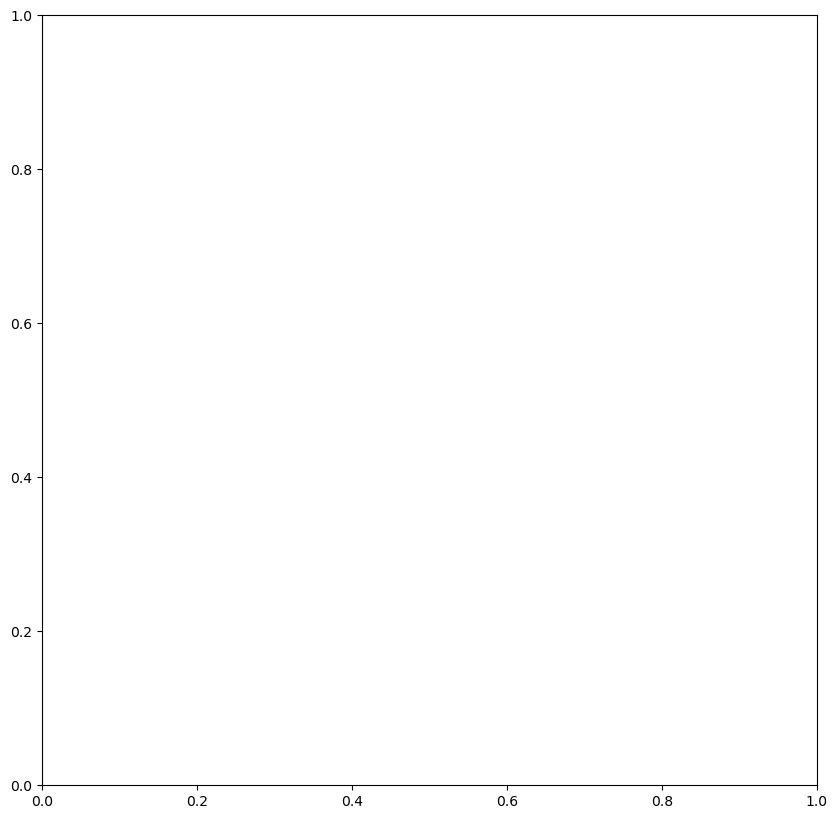

In [39]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geo_plotter", timeout=10)

# Function to get latitude and longitude from an address
def get_lat_lon(address):
    location = geolocator.geocode(address)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply the function to the 'Address' column to get latitudes and longitudes
ww_boxes['latitude'], ww_boxes['longitude'] = zip(*ww_boxes['Address'].apply(get_lat_lon))

# Drop rows with missing latitude or longitude values
ww_boxes = ww_boxes.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame with the points
gdf_points = gpd.GeoDataFrame(ww_boxes, geometry=gpd.points_from_xy(ww_boxes.longitude, ww_boxes.latitude))

# Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
gdf_points.crs = "EPSG:4326"

# Plot the points on the map
oregon = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
oregon = oregon[oregon['name'] == 'United States']
oregon_boundary = oregon.geometry.bounds
ax = oregon.plot(color='white', edgecolor='black', figsize=(10, 10))

gdf_points.plot(ax=ax, color='red', markersize=10, alpha=0.5)


# Customize the plot
plt.title('Map of Portland, OR with Addresses')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()